**Info**: This notebook contains my research note as I gathered the contributorship data for our characterization of credit attribution in open-source.


It begins from a list of repositories to analyze, and by the end we have a clean list of repositories (duplicate dropped), and contributorship data for all of these repositories loaded in a dict.

# Step 1: Construct inital list of repos

We scraped the initial list of repos that use `all-contributors` with a script that calls the GitHub API, via `pygithub`.


* **Script:** [search-github-allcontribs.py](search-github-allcontribs.py)
* **Output:** [../data/search_results_allcontribs__sizeL_sizeU_url.txt](../data/search_results_allcontribs__sizeL_sizeU_url.txt)

In [1]:
import pandas as pd
df = pd.read_csv('../data/search_github_allcontribs_results__sizeL_sizeU_url.txt', names=['sizeL', 'sizeU', 'url'])

To make parsing easier, we'll extract the user / repo pair from the raw url.

In [2]:
# Same technique both time: apply a split to every URL
# The user/repo pair appears right after the first .com/.
df['user'] = df['url'].apply(lambda s: s.split(".com/", 1)[1].split("/")[0])
df['repo'] = df['url'].apply(lambda s: s.split(".com/", 1)[1].split("/")[1])
df['user/repo'] = df['url'].apply(lambda s: "/".join(s.split(".com/", 1)[1].split("/")[0:2]))  # convenient

In [3]:
df.iloc[-1]

sizeL                                                    54250
sizeU                                                    70250
url           https://raw.githubusercontent.com/instaloper/...
user                                                instaloper
repo                                             store-website
user/repo                             instaloper/store-website
Name: 6427, dtype: object

There are some duplicates because of how we initially sized queries (size ranges are inclusive so the ones we have used overlap).
Let's remove them.

In [4]:
df.drop_duplicates('user/repo', inplace=True)

Number of repos in our initial set:

In [5]:
len(df)

6349

# Step 2: Download contributors files

We then downloaded the relevant `all-contributors` file.

To make things easy we'll just call `wget` with `subprocess` instead of using pure python, with the loop below.

(Uncomment and execute to run. **!Warning!**: this will send nearly 6K `wget` queries to GitHub. Runs in about an hour)

In [6]:
# import subprocess
# for row in df.iterrows():
#     data = row[1]
#     # we use the fact that user names can't have double hyphens to separate the filename
#     output_basepath = "../../data/all-contributorsrc/"
#     output_filename =  data['user'] + "--" + data['repo'] + ".txt"
#     query = ['wget',
#              '-O', output_basepath + output_filename,
#              data['url'][1:]]
#     proc = subprocess.run(query, stdout=subprocess.DEVNULL)

# Step 2: Drop ill-formated files

In [7]:
import json

df['ac_file'] = "../../data/all-contributorsrc/" + df['user'] + "--" + df['repo'] + ".txt"
to_remove = set()

accu_file_error = 0
accu_no_contrib = 0
for i, row in df.iterrows():
    (user, repo) = (row['user'], row['repo'])
    
    try:
        with open(row['ac_file'], 'r') as f:
            ac_data = json.load(f)
    except FileNotFoundError:
        to_remove.add(i)
        print("File error with", user, repo)
        accu_file_error += 1
        continue
    except json.JSONDecodeError:
        to_remove.add(i)
        print("Json issue with", user, repo)
        accu_file_error += 1
        continue
    # has contributor field?
    if ac_data.get("contributors") is None:
        to_remove.add(i)
        print("No contributors field for", user, repo)
        accu_no_contrib += 1
        continue
    # has contributor?
    elif len(ac_data.get("contributors")) == 0:
        to_remove.add(i)
        print("No contributors for", user, repo)
        accu_no_contrib += 1
        continue
    # has valid identifiers for contributors
    else:
        remove = False
        for c in ac_data.get("contributors"):
            if c.get('login') is None and c.get('name') is None:
                remove = True
                to_remove.add(i)
        if remove:
            print("No login/name in at least one contributors of", user, repo)
            accu_no_contrib += 1

No contributors for victorhmp react-typescript-training-example
Json issue with Bash-Woman-Community Welcome
No contributors for imgcook imove
No contributors for rysemultiplayer bot-plugins
No contributors for rysemultiplayer bot-pieces
No contributors for rysemultiplayer template
No contributors for urielmmCorebiz pixel-extendido-minisocl
No contributors for United-Music mediainfo
No contributors for United-Music koa-template
No contributors for hsf-training hsf-styles
No contributors for zjffun vue-fill-in-the-blank
No contributors for jsnavarroc react-pdf-simulator
No contributors for vtex-apps product-list-context
Json issue with junjun-li ts-refactor-axios
File error with inkthought website
No contributors for start-at-root react-breeze-form
No contributors for RisingStack react-lib-template
Json issue with mg143pavankumar Portfolio-react
No contributors for urielmmCorebiz pixel-extendido-minisocol
No contributors for monash-human-power ZetaRFTools
No contributors for agroupp lum

No contributors for arm021 gatsby-ikarite
File error with arnabaghorai portfolio
Json issue with smeijer graphql-args
File error with GoldenMaximo store-theme
No contributors for upcwangying eslint-config-aqsc
No contributors for upcwangying eslint-plugin-aqsc
Json issue with mrpilot2 aide
File error with juansernablacksip store-theme
File error with leonardoXoliveira store-theme
No contributors for ad2inc pavbroome
Json issue with nolawi sec-nep
No contributors for tik9 pluralsight-skill-tests
Json issue with CERN slides
File error with rafacamposvtex test
Json issue with ChrisMichaelPerezSantiago tucine-conecta
No contributors for danielclough Immodestea-GhostStorefront
Json issue with ChrisMichaelPerezSantiago cinecoqui
Json issue with nejcm js-algorithms
No contributors for lucaslovato BrickAbodeChallenge
Json issue with LukyVj naturalist.guide
File error with steevz portfolio
No contributors for anishagg17 node-action
File error with miguel-rosa store-theme
File error with tgreff-

Json issue with pyOpenSci pyopensci.github.io
File error with neotericmedia epic-react
File error with kolomiytsevs advanced-react-patterns
File error with bradzickafoose react-hooks
File error with SameerMosesMurala portfolio
File error with dontehightower react-hooks
Json issue with ufersa plataforma-sabia
File error with daviswwang blog
File error with L0rd150 b0mb3r
File error with PhilFuster react-fundamentals
File error with tempyshit b0mb3r
File error with zerothe0ne b0mb3r
File error with XONETAP b0mb3r
File error with starling021 b0mb3r
File error with meetinger b0mb3r
File error with zloynekit156 b0mb3r
File error with Grodas228 b0mb3r
File error with itsyuni b0mb3r
File error with tiagopcastro angular-tomastrajan
File error with Degeron777 b0mb3r
Json issue with aagarwal1012 Animated-Text-Kit
File error with MFredrich react
File error with lionelchris react-native-webview
File error with dmitrijkotov634 b0mb3r
File error with openclimatefix website
Json issue with vdaas vald

File error with kantle netlify-cms
File error with yudahadi14 blog
File error with VosRock netlify-cms
File error with livinggoods snipe
File error with longbkit netlify-cms
File error with perzfred test
File error with l3n641 snipe
File error with fspperez snipeit
File error with sondrele netlify-cms
File error with ciokan netlify-cms
File error with AhmedKandeel netlify-cms
File error with nurulcode nodebestpractices
File error with thiagojmf nodebestpractices
File error with Jieyin19960129 nodebestpractices
File error with railroadpm rrpm-netlify-cms
File error with samposuomesta Netlify-cms
File error with TimothyCSULB nodebestpractices
Json issue with Abpaula p5
File error with korrakorra17 snipe-it
File error with sh1hab snipe
File error with calwongrj1 snipeit
File error with bhargavbuzy snipe
File error with chipsi snipe-it
File error with andybkay snipe-it
File error with cmmsmobile snipe-it
File error with robresn8 snipe
File error with smvap0r snipe-it
File error with jbewin

In [8]:
print("JSON/file errors", accu_file_error)
print("Contrib. errors", accu_no_contrib)

JSON/file errors 625
Contrib. errors 234


In [9]:
df = df.drop(list(to_remove))

Number of repos in our valid list:

In [10]:
len(df)

5490

# Step 3: Repository deduplication

We'll drop forks and focus on the main repositories only.

Below we create a master list of possible impostors.

In [11]:
candidates = set()

## Step 2A:  Prune direct forks

The GitHub API directly marks projects as forks when the fork is created through the GitHub interface.
Our search results do not contain all of these "direct forks", but they do contain some.


I constructed a list of forks and their parent with a script that calls the GitHub API.

* **Script:** [check-fork.py](check-fork.py)
* **Output:** [../data/check-fork_results__fork_parent.txt](../data/check_fork_results__fork_parent.txt)

The data looks like this:

In [12]:
accu = 0
with open('../data/check_fork_results__fork_parent.txt', 'r') as f:
    for line in f:
        data = line.strip().split("\t")
        candidates.add(data[0])
        candidates.add(data[1])
        accu += 1
        print("https://github.com/" + data[0])
        print("https://github.com/" + data[1])
print(accu, "potential pairs.")

https://github.com/jeremie-gauthier/Red-Tetris
https://github.com/redpelicans/red_tetris_boilerplate
https://github.com/ptkdev/eslint-plugin-snakecasejs
https://github.com/deecewan/eslint-plugin-snakecase
https://github.com/Devsoc-BPGC/portfolio-generator-react
https://github.com/arpitbhardwaj24/porfolio-gen
https://github.com/ZBejavu/analytics-challenge-boilerplate
https://github.com/suvelocity/analytics-challenge-boilerplate
https://github.com/RoyShnitzel/DashBoard-Feature-Cypress-App
https://github.com/suvelocity/analytics-challenge-boilerplate
https://github.com/michaelbyalsky/analytics-challenge-michael
https://github.com/suvelocity/analytics-challenge-boilerplate
https://github.com/Remi-Gau/CPP_BIDS
https://github.com/cpp-lln-lab/CPP_BIDS
https://github.com/AmirDebbie/Analytics
https://github.com/suvelocity/analytics-challenge-boilerplate
https://github.com/chenxingxing6/hera
https://github.com/zhengfeiafei/hera
https://github.com/cpp-lln-lab/CPP_SPM
https://github.com/mohmdrezk/


## Step 2B: Further pruning with deduplicates dataset

Some forks are created by clone-pushes and the `fork` filter above will not work. We remove these with the dataset of Spinellis and collaborators (see https://zenodo.org/record/3653920#.X-o-e1OYWfU). 

**Caveat:** *The dataset is a few months old and will miss some dupes*.

There are two files in this dataset.
One, `deduplicate_names.txt` lists repos alongside their (likely) parent.
The other, `forks_clones_noise_names.txt`, contains file not used in the mapping based on search heuristics (see [paper](https://dl.acm.org/doi/10.1145/3379597.3387496)).
We only want to exclude the repos that appear in the former.

In [13]:
fork_db = dict()
# NB: deduplicate_names is ~500 MB so not included in the repo, should be downloaded from the zenodo link (same as above):
# https://zenodo.org/record/3653920#.X-o-e1OYWfU
with open('../../data/deduplicate_names.txt', 'r') as f:
    for line in f:
        data = line.strip().split()
        fork_db[data[0]] = data[1]  # in user/repo format
        
        
fork_filter = df['user/repo'].apply(lambda p: p in fork_db)
print("Found", fork_filter.sum(), "potential dupes.")

Found 95 potential dupes.


In [14]:
for row in df[fork_filter].iterrows():
    print("https://github.com/" + row[1]['user/repo'])
    candidates.add(row[1]['user/repo'])

https://github.com/moja-global/Import-Me
https://github.com/mubaidr/bulma-fluent
https://github.com/phpid-jakarta/www-smesummit.id-2019
https://github.com/kevinahuber/whoisresponsible.us
https://github.com/VisualComputing/Transformations
https://github.com/johnjacobkenny/abstract-interface-example
https://github.com/vtex-apps/store-theme
https://github.com/WandersonAlves/generator-kube-microservice-node
https://github.com/Byteclaw/forms
https://github.com/silverspectro/vue-clickaway2
https://github.com/auxilincom/deploy-drone
https://github.com/Meteor-Community-Packages/meteor-link-accounts
https://github.com/me-io/angular-7-starter
https://github.com/arwes/arwes
https://github.com/4qu3l3c4r4/W3C_WebDriver
https://github.com/SavageCore/node-ffprobe-installer
https://github.com/LoLei/razer-cli
https://github.com/s-yadav/iv-viewer
https://github.com/adswa/multimatch_gaze
https://github.com/ritz078/raaga
https://github.com/matthewhudson/current-device
https://github.com/tensorspace-team/t

## Step 2C: Fuzzy match

In [15]:
from fuzzywuzzy import fuzz
import numpy as np
import multiprocessing
from multiprocessing import sharedctypes

# init a shared array
num_repos = len(df)
sim = np.ctypeslib.as_ctypes(np.zeros((num_repos, num_repos)))
shared_array = sharedctypes.RawArray(sim._type_, sim)

# this function fills a single row of the shared array with the fuzz.WRatio similarity
def fill_row(row_id):
    tmp = np.ctypeslib.as_array(shared_array)
    for i in range(num_repos):
        tmp[row_id, i] = fuzz.WRatio(df['repo'].iloc[row_id], df['repo'].iloc[i])

# fill array on 100 thread (will be VERY slow on small machines)
pool = multiprocessing.Pool(100)
proc = pool.map(fill_row, range(num_repos))
pool.close()
pool.join()

# "localize" array 
sim = np.array(np.ctypeslib.as_array(shared_array))

Viz distance

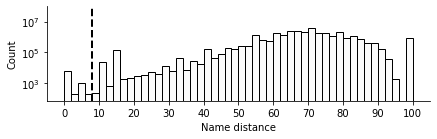

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(100 - sim.flatten(), bins=50, height=2, aspect=3, color="#FAFAFA", linewidth=1.)
plt.xlabel('Name distance')
plt.xticks(np.arange(0,110,10));
plt.gca().set_yscale('log')
plt.ylim(70, 1e8)
plt.axvline(8, c='k', ls='--', lw=2)

Then we can cluster based on this distance.

DBSCAN is highly scalable and doesn't require the number of cluster as input, so let's use this one.

As we see from the distance figure above, a threshold in between 2 and 10 ought to do due to the gap there.

In [17]:
# cluster with sklearn
import sklearn.cluster
dbscan = sklearn.cluster.DBSCAN(metric='precomputed',eps=8, n_jobs=10)
dbscan.fit(100 - sim)

DBSCAN(eps=8, metric='precomputed', n_jobs=10)

We found a bunch of clusters of potential duplicates

In [18]:
print("Found", len(set(dbscan.labels_)) - 1, "clusters.")

Found 28 clusters.


In [19]:
accu = 0
for match in df.groupby(dbscan.labels_)['user/repo'].apply(list).iloc[1:]:
    print("=== New group ===")
    for m in match:
        print("https://github.com/" + m)
        candidates.add(m)
        accu += 1

=== New group ===
https://github.com/mskelton/eslint-config
https://github.com/vas-dev/eslint-config
https://github.com/ehmicky/eslint-config
https://github.com/devoxa/eslint-config
https://github.com/skyra-project/eslint-config
https://github.com/wellyshen/eslint-config-welly
=== New group ===
https://github.com/Dark-Heresy/front-end
https://github.com/Parteiduell/frontend
https://github.com/lsglab/frontend
https://github.com/ContactTracing-app/Frontend
https://github.com/howtocards/frontend
https://github.com/MhdAsad-Pro/Front_End
https://github.com/satolist/frontend
=== New group ===
https://github.com/preons/docs
https://github.com/opengraphimg/docs
https://github.com/hn-ui/docs
https://github.com/simple-swoole/docs
https://github.com/eesast/docs
https://github.com/jasonelle-archive/docs
https://github.com/laravelkr/docs
=== New group ===
https://github.com/nekko-ru/api
https://github.com/africa-covid-19-response-toolkit/api
https://github.com/sapphire-project/api
https://github.co

In [20]:
print(accu, "potential dupes.")

291 potential dupes.


## Step 2D: Ownership mismatch

The next source of data we investigated was ownership mistmatch, were the information declared in all-contributors file does not match the repo. 

In [21]:
accu_mismatch = 0
accu_no_owner = 0
for i, row in df.iterrows():
    with open(row['ac_file'], 'r') as f:
        ac_data = json.load(f) 
        try:
            if ac_data['projectOwner'] != row['user'] or ac_data['projectName'] != row['repo']:
                print("Mistmatch", "https://github.com/" + row['user/repo'], "(declared as", ac_data['projectOwner'] +"/"+ ac_data['projectName'], ")")
                candidates.add(row['user/repo'])
                accu_mismatch += 1
        except KeyError:
            print("No owner info for", row['user/repo'])
            candidates.add(row['user/repo'])
            accu_no_owner += 1

Mistmatch https://github.com/moja-global/FLINT.User_Guide (declared as moja-global/Import-Me )
Mistmatch https://github.com/moja-global/FLINT.Cloud (declared as moja-global/Import-Me )
Mistmatch https://github.com/forestryio-templates/cloudinary-lightbox (declared as forestryio/Cloudinary Lightbox )
Mistmatch https://github.com/me-io/docker-php-dev (declared as /docker-php )
Mistmatch https://github.com/QSolutionsLLC/cornerstonejs-marketplace (declared as dannyrb/cornerstonejs-marketplace )
Mistmatch https://github.com/back8/github_repo-sync_repo-sync (declared as repo-sync/repo-sync )
Mistmatch https://github.com/khoahappy/my-resume (declared as amandeepmittal/gatsby-starter-ceevee )
Mistmatch https://github.com/auxilincom/deploy-logging (declared as auxilin/deploy-logging )
Mistmatch https://github.com/axetroy/wxapp-fetch (declared as gpmer/gpm.js )
Mistmatch https://github.com/axetroy/webuild (declared as axetroy/Github )
Mistmatch https://github.com/mrhut10/cv_play (declared as imp

Mistmatch https://github.com/matheus-azevedo-corebiz/matheusvtex (declared as vtex-apps/store-theme )
Mistmatch https://github.com/loatheb/100-lines-of-code-challenge-js (declared as loatheb/tiny-all-over-the-world )
Mistmatch https://github.com/ease-live/nanogram.js (declared as webistomin/nanogram.js )
Mistmatch https://github.com/marcoseplus/testehackathon (declared as vtex-apps/store-theme )
Mistmatch https://github.com/GabiDanciu/store-framework-forReact (declared as vtex-apps/store-theme )
Mistmatch https://github.com/muscogee-language-foundation/admin.creekdictionary.com (declared as nativesintech/muscogee-creek-dictionary-admin )
Mistmatch https://github.com/lindomarNascimento/vtex-io-first-project (declared as vtex-apps/store-theme )
Mistmatch https://github.com/tsuki42/react-get-request (declared as tsuki42/cra-ts-tailwindcss-template )
Mistmatch https://github.com/dev-generator/app.devgenerator.io (declared as chiefpansancolt/developer-file-generator )
Mistmatch https://gith

Mistmatch https://github.com/yespark/haml-lint-action (declared as andrewmcodes/haml-lint-action )
Mistmatch https://github.com/DanPete/tailwind-ecom-next (declared as taylorbryant/next-starter-tailwind )
Mistmatch https://github.com/RedSkiesIO/vuex-orm-plugin-lokijs (declared as nshCore/community )
Mistmatch https://github.com/africa-covid-19-response-toolkit/housing-vacancy-bot (declared as Ethiopia-COVID19/Hotel-Vacancy-Telegram-Bot )
Mistmatch https://github.com/bradmccray89/vue-electron-downloader (declared as mubaidr/vue-electron-template )
Mistmatch https://github.com/sitesecure312/react-native-app (declared as expo/create-react-native-app )
Mistmatch https://github.com/v13l/tekweb-blog (declared as taylorbryant/next-starter-tailwind )
Mistmatch https://github.com/Sentenai/reinforce (declared as stites/reinforce )
Mistmatch https://github.com/ojasvi92/Delivery-slot-notifier-Amazon-Fresh-COVID-19 (declared as ojasvi92/Amazon-Fresh-Delivery-Slot-Notifier-COVID-19 )
Mistmatch https

Mistmatch https://github.com/editmodelabs/editmode-react (declared as Editmode-app/editmode-react )
Mistmatch https://github.com/technikhil314/angular-components (declared as technikhil314/auto-badger )
Mistmatch https://github.com/nodejs/examples (declared as node/examples )
Mistmatch https://github.com/devcreatives/md2urdu (declared as Techistan/md2urdu )
Mistmatch https://github.com/gparlakov/scuri (declared as Georgi Parlakov/scuri )
Mistmatch https://github.com/moja-global/FLINT.Module.Agricultural_Soil_Model (declared as moja-global/GSoC.FLINT.Module.Agricultural_Soil_Model )
Mistmatch https://github.com/react-boilerplate/react-boilerplate-typescript (declared as react-boilerplate-typescript/react-boilerplate-typescript )
Mistmatch https://github.com/yldio/graphql-workshop (declared as SaraVieira/graphql-workshop )
Mistmatch https://github.com/ptkdev-components/webcomponent-instagram-widget (declared as ptkdev/ptkdev-components/webcomponent-instagram-widget )
Mistmatch https://gi

Mistmatch https://github.com/greysian777/RLabCloneX (declared as MinorMole/RcloneLab )
Mistmatch https://github.com/codebytes-io/codebytes (declared as taylorbryant/gatsby-starter-tailwind )
Mistmatch https://github.com/ibaljeetvisions/react_app_auth (declared as FormidableLabs/react-native-app-auth )
Mistmatch https://github.com/livingmine/abroad-hemat (declared as Oddstronaut/gatsby-starter-tailwind )
Mistmatch https://github.com/iamrxheem/cxcguide.com (declared as taylorbryant/gatsby-starter-tailwind )
Mistmatch https://github.com/Mustafiz04/Mustafiz04.github.io (declared as ashutosh1919/masterPortfolio )
Mistmatch https://github.com/hightower86/undef-project (declared as Oddstronaut/gatsby-starter-tailwind )
Mistmatch https://github.com/kunaljoshi5967/kunaljoshi59674.github.io (declared as ashutosh1919/masterPortfolio )
Mistmatch https://github.com/Tanya-Goel/my_wiki (declared as Tanya-Goel/masterPortfolio )
Mistmatch https://github.com/g-shreekant/shreekantgosavi.github.io (declar

Mistmatch https://github.com/MeleshkoYuliya/formik (declared as jaredpalmer/formik )
Mistmatch https://github.com/sukumarvaddi/KentHooksWorkShop (declared as kentcdodds/react-hooks )
Mistmatch https://github.com/devjones/formik-dist (declared as jaredpalmer/formik )
Mistmatch https://github.com/pixelverso/formdr2 (declared as ohmyform/OhMyForm )
Mistmatch https://github.com/vanugula/applications (declared as jaredpalmer/formik )
Mistmatch https://github.com/shegaoyuan/explorer-frontend (declared as Cosmostation/mintscan-binance-dex-frontend )
Mistmatch https://github.com/MathisGuilhin/CREATIS-OHIFViewer-dev (declared as OHIF/Viewers )
Mistmatch https://github.com/velin666/HSChain_bowsers (declared as Cosmostation/mintscan-hschain-dex-frontend )
Mistmatch https://github.com/ivansukach/mintscan-explorer (declared as Cosmostation/mintscan-binance-dex-frontend )
Mistmatch https://github.com/CodeIsaMystic/kentcdodds-testing-workshop-jowd (declared as kentcdodds/testing-workshop )
Mistmatch 

Mistmatch https://github.com/yocto-erp/yocto-erp-web (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/gnurt250394/template-web (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/venkatesh-soulpage/boozeboss-app (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/rmurgatroyd/influencer-form-v2 (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/shivambhalla1234/Resume-Builder-test (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/legesher/legesher-dot-io (declared as madiedgar/legesher-dot-io )
Mistmatch https://github.com/phamner/DovenmuehleProject (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/AnnaMinasian/streem-test-task (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/SamGrig96/EachBase (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/Elmiira/po

Mistmatch https://github.com/Ibbus93/react-boilerplate-test (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/imam76/studyeasy (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/aatifvikar/car-configurator (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/Hope-2020/track-book-styled-components (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/pisharodySrikanth/dashboard-interface (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/namrathapamarthi/CSC691 (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/roshanmirajkar/KSWeb-MVP (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/sindu12jun/react-bio (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/marsonmao/data-table (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/popovic

Mistmatch https://github.com/dolad/react-setup (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/pedric/pedric.github.io (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/cwadeking/squawk-box (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/x48-crypto/yearn-contributors (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/reactnative0336/react-native-webview-UPDATED (declared as react-native-community/react-native-webview )
Mistmatch https://github.com/mrsohailahmed/react-boilerplate-react-boilerplate. (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/digleg/golden-boy-tennis (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/nytro04/pepsi-landing (declared as react-boilerplate/react-boilerplate )
Mistmatch https://github.com/rakesh-talukdar/kanban-board-v2 (declared as react-boilerplate/react-boilerplate )
Mist

Mistmatch https://github.com/amira-d/amira-d.github.io (declared as Amira Doghri/developerFolio )
Mistmatch https://github.com/freddiefujiwara/freddiefujiwara.github.io (declared as saadpasta/developerFolio )
Mistmatch https://github.com/trivip2000/porfolio (declared as saadpasta/developerFolio )
Mistmatch https://github.com/julius-svg/neat (declared as saadpasta/developerFolio )
Mistmatch https://github.com/sravanidnd/react-fundamentals-kent-c (declared as kentcdodds/react-fundamentals )
Mistmatch https://github.com/conventional-changelog-archived-repos/validate-commit-msg (declared as kentcdodds/validate-commit-msg )
Mistmatch https://github.com/ChristopherDalziel/Epic-React-Advanced-Hooks (declared as kentcdodds/advanced-react-hooks )
Mistmatch https://github.com/Armmand/newporfolio (declared as saadpasta/developerFolio )
Mistmatch https://github.com/hnakao/portafolio (declared as saadpasta/developerFolio )
Mistmatch https://github.com/monmon8/epicreact (declared as kentcdodds/react

Mistmatch https://github.com/arun-thakur/nodepractice (declared as goldbergyoni/nodebestpractices )
Mistmatch https://github.com/Dickson-Mwendia/NodeJS-Dev-Best-Practices (declared as goldbergyoni/nodebestpractices )
Mistmatch https://github.com/mustafa-synectiks/main-netlify-cms (declared as netlify/netlify-cms )
Mistmatch https://github.com/18939295085/web-interview (declared as h5bp/Front-end-Developer-Interview-Questions )
Mistmatch https://github.com/lucasmzz/frontend-interview-questions (declared as h5bp/Front-end-Developer-Interview-Questions )
Mistmatch https://github.com/InHeDEV/netify-project (declared as netlify/netlify-cms )
Mistmatch https://github.com/waterfield-tech/stub-city (declared as formium/tsdx )
Mistmatch https://github.com/saurabhchaudhary3613/Front-end-Developer-Interview-Questions (declared as h5bp/Front-end-Developer-Interview-Questions )
Mistmatch https://github.com/miracle-arrow/Netfly-CMS (declared as netlify/netlify-cms )
Mistmatch https://github.com/hack

In [22]:
print("Owner mismatches", accu_mismatch)
print("No owner info", accu_no_owner)

Owner mismatches 2640
No owner info 3


## Step 2E: Partial vetting

Note all of the above candidates should be removed so we had to check them.

This is a laborious undertaking so we assumed that, by default, a repo would be removed but that we could "save them".

I inspected all the candidates found with the fork criterion, the Spinnelis dataset and the fuzzy match, as well as spot-checked ownership mistmatch. This gave me a list of 142 repository to save.
This list is available [here](../../data/vetted_repos.txt).


All in all, we went down from:

In [23]:
print("Potential candidates", len(candidates))

Potential candidates 2789


But once vetted:

In [24]:
with open('../data/vetted_repos.txt', 'r') as f:
    for l in f:
        candidates.remove(l.strip())

In [25]:
print("Potential candidates", len(candidates))

Potential candidates 2647


In [26]:
with open('../data/dropped_repos.txt', 'w') as f:
    for r in candidates:
        print(r, file=f)

## Step 2F: Final filtering

Joining all of these filter together we find the following filter:

In [27]:
fork_filter = df['user/repo'].apply(lambda p: p in candidates)
print("Removed:")
df[fork_filter]

Removed:


,sizeL,sizeU,url,user,repo,user/repo,ac_file
6,0,500,https://raw.githubusercontent.com/moja-global...,moja-global,FLINT.User_Guide,moja-global/FLINT.User_Guide,../../data/all-contributorsrc/moja-global--FLI...
12,0,500,https://raw.githubusercontent.com/moja-global...,moja-global,FLINT.Cloud,moja-global/FLINT.Cloud,../../data/all-contributorsrc/moja-global--FLI...
25,0,500,https://raw.githubusercontent.com/forestryio-...,forestryio-templates,cloudinary-lightbox,forestryio-templates/cloudinary-lightbox,../../data/all-contributorsrc/forestryio-templ...
27,0,500,https://raw.githubusercontent.com/me-io/docke...,me-io,docker-php-dev,me-io/docker-php-dev,../../data/all-contributorsrc/me-io--docker-ph...
35,0,500,https://raw.githubusercontent.com/QSolutionsL...,QSolutionsLLC,cornerstonejs-marketplace,QSolutionsLLC/cornerstonejs-marketplace,../../data/all-contributorsrc/QSolutionsLLC--c...
...,...,...,...,...,...,...,...
6422,54250,70250,https://raw.githubusercontent.com/moltypod/et...,moltypod,ether22,moltypod/ether22,../../data/all-contributorsrc/moltypod--ether2...
6423,54250,70250,https://raw.githubusercontent.com/moltypod/et...,moltypod,ether2,moltypod/ether2,../../data/all-contributorsrc/moltypod--ether2...
6424,54250,70250,https://raw.githubusercontent.com/ujely/x1/ec...,ujely,x1,ujely/x1,../../data/all-contributorsrc/ujely--x1.txt
6426,54250,70250,https://raw.githubusercontent.com/pbhardwajj/...,pbhardwajj,p5.pulkit,pbhardwajj/p5.pulkit,../../data/all-contributorsrc/pbhardwajj--p5.p...


Next we apply the filter.

In [28]:
df = df[~fork_filter]

This leaves us with ...

In [29]:
print("Number of remaining repos:", len(df))

Number of remaining repos: 2855


In [30]:
with open('../data/final_repos.txt', 'w') as f:
    for idx, row in df.iterrows():
        print(row['user/repo'], file=f)

# Step 3: get automated contributorships data

In this step we gather contribution data.

We gather those with the octohatrack service.


#### Octohatrack Service data

Using a [quick search](https://github.com/LABHR/octohatrack_service/commit/7ad304f072ffe4119884f9b00d843ebd96476c30) CLI on top of the bigquery-based search, results for the github events were able to be collected quicker than a manual GitHub API walking method. 

#### Reproduction steps

```shell
# Clone code
git clone git@github.com:LABHR/octohatrack_service
cd octohatrack_service

# Setup virtualenv
virtualenv venv
source venv/bin/activate

# Install dependencies
pip install -r requirements.txt

# Collect list of repos
cp ../data/repo_list.txt .

# Run cli
time python cli.py --repo-list repo_to_scrape.txt --debug > repo_results.txt
```

#### Results

Results are in a CSV form `reponame,event,username`, where:

 * `reponame` is the github organisation/user, and repo name, 
 * `event` is: 
    * [the GitHub Event API event](https://docs.github.com/en/free-pro-team@latest/developers/webhooks-and-events/github-event-types), or
    * `api_contributor` for data from the GitHub API for the raw contributors list. 
 * `username` is the github user name. 

Data collected in `repo_results.txt` processed Jan 5 2020.

Process created a 175M octohatrack cache (available on request) 





# Step 4: get top-contributors data

This step is run externally.

* **Script:** [top-github-contributors.py](top-github-contributors.py)
* **Output:** [../data/tc-contributors/](../data/tc-contributors/)

but the script is simple:

```python
# boot up github instance
with open("secret.txt", "r") as f:
    token = f.readline().strip()  
g = Github(token)


with open("../data/final_repos.txt", "r") as repo_list:
    for repo in repo_list:
        # check if scraping already done
        outfile_name = "../data/gh-topcontributors/" + repo.strip().replace("/", "_") + ".json"
        if pathlib.Path(outfile_name).is_file():
            print("[Skipping]", repo.strip())
            continue
        # query contributors
        print(repo.strip())
        try:
            query = g.get_repo(repo.strip()).get_contributors()
            # build list of contributors
            repo_data = {'contributors': []}
            for user in query:
                repo_data['contributors'].append({'login': user.login,
                                                  'name': user.name,
                                                  'url': user.html_url,
                                                  'email': user.email})
            # save to file
            with open(outfile_name, "w") as outfile:
                json.dump(repo_data, outfile, indent=2)
        except GithubException as e:
            print("   Does not exist.")

        # sleep to avoid hitting rate limits    
        time.sleep(1)
```

(For path-dependent reasons, the number of scraped repositories is higher than our sample size, because scraped data on duplicates.)

In [31]:
import os
print("Number of scraped repositories:", len(os.listdir('../data/gh-topcontributors/')))

Number of scraped repositories: 5480


# Step 5: get meta-data

The final data source is repository meta-data. Again this is just a simple loop over repo combined with API calls to extract relevant information.

This step is run externally.

* **Script:** [scrape-metadata.py](scrape-metadata.py)
* **Output:** [../data/gh-metadata/](../data/gh-metadata/)

The meta data we gather looks like this

```json
{
  "languages": {
    "JavaScript": 84251
  },
  "profile": {
    "code_of_conduct": true,
    "readme": true,
    "contributing": false,
    "license": false,
    "issue_template": false,
    "pull_request_template": false,
    "description": true
  },
  "stars": 1,
  "forks": 0,
  "commits": 73
}

```

In [32]:
import os
print("Number of scraped repositories:", len(os.listdir('../data/gh-metadata/')))

Number of scraped repositories: 2846


# Step 6: prepare data

Now that we have our final list of repositories and have downloaded all the data, the final step is to consolidate everything in a single object.

## Step 6A: load everything in a dictionary

First let's deal with All Contributors and Top Contributors, which have roughly similar format

In [33]:
df['ac'] = "../data/all-contributorsrc/" + df['user'] + "--" + df['repo'] + ".txt"
df['tc'] = "../data/gh-topcontributors/" + df['user'] + "_" + df['repo'] + ".json"
df.reset_index(inplace=True)
    
def _get_contrib(index, df, scheme, datapath):
    with open(datapath + df[scheme].iloc[index], 'r') as f:
        data = json.load(f)
    return data

def get_ac(index, df=df, datapath = '../data/'):
    """Retrieve the all-contributors info of the repository at the specified index value."""
    return _get_contrib(index, df, 'ac', datapath)

def get_tc(index, df=df, datapath = '../data/'):
    """Retrieve the topcontributors info of the repository at the specified index value."""
    return _get_contrib(index, df, 'tc', datapath)

In [34]:
db = dict()
for (idx, row) in df.iterrows():
    (user, repo) = (row['user'], row['repo'])
    try:
        data = {'ac': get_ac(idx),
                'tc': get_tc(idx)}
        db[(user, repo)] = data
    except FileNotFoundError:
        print("File error with", user,repo)
        continue
    except json.JSONDecodeError:
        print("Json issue with", user,repo)
        continue

File error with mskelton prettier-config
File error with mskelton babel-config
File error with mskelton whi
File error with mskelton vscode-lockfile-viewer
File error with mskelton stylelint-plugin-sort
File error with skyverge tackle-box


Now let's do octohatrack

In [35]:
with open("../data/octohatrack_service/repo_results.txt", 'r') as f:
    for l in f:
        repo_id, contribType, login = l.strip().split(",")
        if contribType == 'Event' or contribType == 'api_contributor':
            continue
        user, repo = repo_id.split("/", 1)
        if (user, repo) not in db:
            continue
        if db[(user, repo)].get('octo') is None:
            db[(user, repo)]['octo'] = {login: [contribType]}
        else:
            if db[(user, repo)]['octo'].get(login) is None:
                db[(user, repo)]['octo'][login] = [contribType]
            else:
                db[(user, repo)]['octo'][login].append(contribType)

for p in db:
    if db[p].get('octo') is None:
        print(p)
        db[p]['octo'] = []

('md-cs-student-unipi', 'ICT-Infrastructures')
('jasonelle-archive', 'docs')


We'll also load the meta data

In [36]:
meta_data_db =  dict()

for project in db:
    try:
        with open("../data/gh-metadata/" + "_".join(project) + ".json", 'r') as f:
            data = json.load(f)
        meta_data_db[project] = data
    except FileNotFoundError as e:
        print(e)
        continue

[Errno 2] No such file or directory: '../../data/gh-metadata/wongbejoonline_eslint-plugin-wbo.json'
[Errno 2] No such file or directory: '../../data/gh-metadata/sapphire-project_api.json'
[Errno 2] No such file or directory: '../../data/gh-metadata/siapbantu_siapbantu.website.json'


## Step 6B: Normalize data

To make things easy to analyze, we'll use the following nested dictionnary in lieu of a database:

    `project -> people -> contributions (per system)` 
    
We'll also store the metadata separately:

    `project -> data`

The following code normalize the contribution data to follow this format (the meta data is already in the correct format).

In [39]:
final_db = dict()

for project in db:
    # create list of contributors by joining sets of contributors according the all systems
    contribs = set()
    for user in db[project]['ac']['contributors']:
        if user.get('login') is not None:
            contribs.add(user['login'])
        elif user.get('name') is not None:  # some users are only acknowledged by name and not login
            contribs.add(user['name'])
        else:
            raise('Invalid data.')
    contribs = contribs.union({u['login'] for u in db[project]['tc']['contributors']})
    contribs = contribs.union({u for u in db[project]['octo']})
    # convert contribs to dict
    contribs = {c: {'ac': [], 'octo': [], 'tc': False} for c in contribs}
    # load all-contributors
    for c in db[project]['ac']["contributors"]:
        if c.get('login') is not None:
            contribs[c['login']]['ac'] = c['contributions']
        else:
            contribs[c['name']]['ac'] = c['contributions']
    # load octohatrack
    for c in db[project]['octo']:
        contribs[c]['octo'] = db[project]['octo'][c]
    # top contributors:
    for count, c in enumerate(db[project]['tc']['contributors']):
        if count == 100:  # keep first 100
            break
        contribs[c['login']]['tc'] = True
    # add to DB
    final_db[project] = contribs

# Step 7: purge bots

Finally we'll remove bots from our data.

Data before purge:

In [41]:
accu = 0
for project in final_db:
    for c in final_db[project]:
        accu += 1

In [42]:
print("Project-login pairs:", accu)

Project-login pairs: 149665


In [43]:
# these users have a login that does not contain bot but they are boths
bots = {"allcontributors", "renovate",  "stale", "github-actions"} 
# these users have a login ending in "bot" but they are not bots
safe = {"adamscybot", "aktsbot", "andrebot", "apirobot", "bashfulrobot", "bchrobot", "benbot", "bobtherobot", "boenrobot", "ceejbot", "charliesbot", "chri5bot", "danobot", "dawsbot", "Ddbot", "dev-rowbot", "domtalbot", "goaddbot", "ichabot", "joshuabot", "jotterbot", "Jugbot", "jukbot", "kebot", "Labrobot", "LionelMarbot", "mikechabot", "mikhailbot", "muta-robot", "namithubot", "naviabbot", "olgabot", "p3x-robot", "reconbot", "sagalbot", "shawnbot", "sunlingbot", "the-robot", "therebelrobot", "ttalbot", "VincentNarbot", "webot", "wootsbot", "yonibot", "ytkopobot"}

accu = 0
for p in final_db:
    for b in bots:
        try:
            del final_db[p][b]
            accu += 1
        except KeyError:
            pass
    to_remove = set()
    for c in final_db[p]:
        if "-bot" == c[-4:]:
            to_remove.add(c)
            accu += 1
        elif "[bot]" == c[-5:]:
            to_remove.add(c)
            accu += 1  
        elif "bot" == c[-3:] and c not in safe:
            to_remove.add(c)
            accu += 1
    for b in to_remove:
        del final_db[p][b]
print("Removed", accu , "entries.")

Removed 7066 entries.



# Step 8: Save databases

In [44]:
import pickle

In [45]:
# pickle
with open('../data/contributors-data.pck', 'wb') as f:
    pickle.dump(final_db, f)
with open('../data/metadata.pck', 'wb') as f:
    pickle.dump(meta_data_db, f)